In [158]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

def open_sheet(sheet_name):
    return pd.read_excel(sheet_name)

def alterar_coluna_dataHora(dataframe):
    dataframe = dataframe.astype({'Hora':'string'})
    print("Alterou Type")
    for x in range(len(dataframe)):
        value=dataframe.loc[x,"Datahora"]
        split=value.split(":")
        dataframe.loc[x,'Datahora'] = split[0]
        dataframe.loc[x,"Mês"]=split[1].lstrip('0')
        dataframe.loc[x,'Hora'] = value.split(" ")[1]
    return dataframe

def alterar_coluna_dia(dataframe):
    dataframe = dataframe.astype({'Dia':'string'})
    print("Antes do for")
    for i in range(dataframe.shape[0]):
        val = dataframe.loc[i,'Dia']
        i_dia = val.split(' ')[0].split('-')[2]
        dataframe.loc[i,'Dia'] = i_dia
    print("Depois do for")
    return dataframe

def get_1000_de_cada_file(df_files):
    all_df=[]
    for df_year in df_files:
        print("Novo ano")
        total_lines = df_year.shape[0]
        all_df_year = []
        for j in range(1,13):
            df_month = df_year[df_year['Mês']==str(j)]
            perc_total_amostra = df_month.shape[0]/total_lines
            # print("Mês "+str(j)+" Percentagem: "+str(perc_total_amostra))
            all_df_year.append(df_month.sample(n = int(perc_total_amostra*1000)+1))
        all_df.append(pd.concat(all_df_year))
    return pd.concat(all_df)

def get_sample():
    df_files = []
    for i in range(10):
        filename = "201"+str(i)+"Acidentes.xlsx"
        print("File: "+filename)
        df_temp = open_sheet(filename)
        df_files.append(alterar_coluna_dataHora(df_temp))
    # return df_files[0]
    df_excel = get_1000_de_cada_file(df_files)
    df_excel = df_excel.rename(columns = {'Datahora':'Ano'}, inplace = False)
    df_excel.to_excel("10000_sample.xlsx")

def mostrar_distribuicao_temporal():
    df_2010=open_sheet("2010Acidentes.xlsx")
    print("Antes for")
    total_lines = df_2010.shape[0]
    for x in range(total_lines):
        value=df_2010.loc[x,"Datahora"]
        split=value.split(":")[1]
        df_2010.loc[x,"Mês"]=split.lstrip('0')
    all_df_year = []
    list_percen = []
    for j in range(1,13):
        df_month = df_2010[df_2010['Mês']==str(j)]
        perc_total_amostra = df_month.shape[0]/total_lines
        list_percen.append(perc_total_amostra)
        all_df_year.append(df_month.sample(n = int(perc_total_amostra*1000)+1))
    df_res = pd.concat(all_df_year)
    list_percen_after = []
    for j in range(1,13):
        df_month = df_res[df_res['Mês']==str(j)]
        perc_total_amostra = df_month.shape[0]/df_res.shape[0]
        list_percen_after.append(perc_total_amostra)
    fig = plt.figure(figsize = (10,10))
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.plot(df_2010['Mês'].unique().astype(int),list_percen)
    ax1.set_title("Antes de reduzir")
    plt.legend(["n="+str(total_lines)])
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.plot(df_res['Mês'].unique().astype(int),list_percen_after)
    ax2.set_title("Depois de reduzir")
    plt.legend(["n="+str(df_res.shape[0])])
    plt.show()
    print("Antes de reduzir: \n"+str(list_percen))
    print("Depois de reduzir: \n"+str(list_percen_after))
    return df_res

# teste()


Antes for


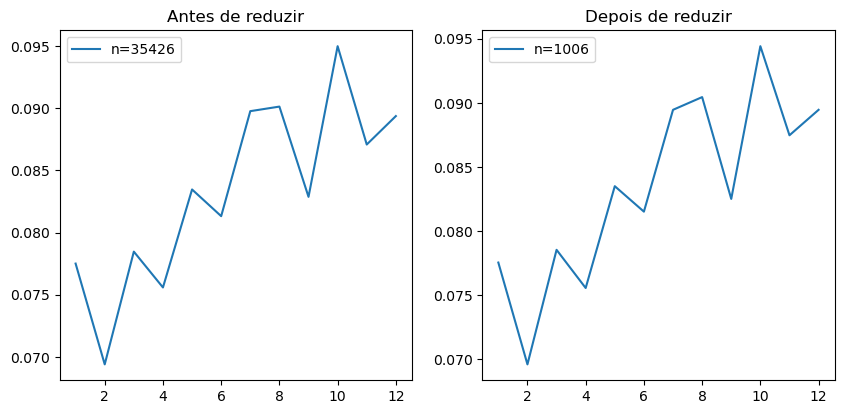

Antes de reduzir: 
[0.07751369050979506, 0.06941229605374584, 0.07847343758821204, 0.07559419635296111, 0.08346976796702986, 0.08132445096821543, 0.08976457968723536, 0.09013154180545362, 0.08287698300683113, 0.09498673290803365, 0.08708293343871733, 0.08936938971376955]
Depois de reduzir: 
[0.0775347912524851, 0.06958250497017893, 0.07852882703777336, 0.07554671968190854, 0.08349900596421471, 0.08151093439363817, 0.08946322067594434, 0.09045725646123261, 0.08250497017892644, 0.09443339960238568, 0.0874751491053678, 0.08946322067594434]


,Id. Acidente,Datahora,Dia,Mês,Hora,Entidades Fiscalizadoras,Velocidade local,Velocidade geral,Dia da Semana,Latitude GPS,...,Obstáculos,Sentidos,Sinais,Sinais Luminosos,Tipo Piso,Traçado 1,Traçado 2,Traçado 3,Traçado 4,Via Trânsito
2369,2010442197,2010:01:27 08:50:00,1900-01-27,1,1900-01-01 08:50:00,Guarda Nacional Republicana,120.0,120.0,Quarta-Feira,"39,912936",...,Inexistentes,No sentido crescente da quilometragem,NÃO DEFINIDO,Inexistentes,Betuminoso,Recta,Em patamar,Berma pavimentada,Em plena via,Esquerda
849,2010437469,2010:01:10 16:20:00,1900-01-10,1,1900-01-01 16:20:00,Guarda Nacional Republicana,50.0,90.0,Domingo,"40,288907",...,Inexistentes,NÃO DEFINIDO,Outros,Inexistentes,Betuminoso,Recta,Em patamar,Berma pavimentada,Em plena via,Direita
42,2010441994,2010:01:01 12:45:00,1900-01-01,1,1900-01-01 12:45:00,Guarda Nacional Republicana,50.0,50.0,Sexta-Feira,"41,419858",...,Inexistentes,NÃO DEFINIDO,Outros,Inexistentes,Betuminoso,Recta,Em patamar,Berma não pavimentada,Na berma,Direita
708,2010442712,2010:01:08 18:50:00,1900-01-08,1,1900-01-01 18:50:00,Guarda Nacional Republicana,90.0,90.0,Sexta-Feira,"38,73517",...,Inexistentes,NÃO DEFINIDO,Outros,Inexistentes,Betuminoso,Curva,Em patamar,Sem berma ou impraticável,Em plena via,Direita
1429,2010427036,2010:01:16 08:00:00,1900-01-16,1,1900-01-01 08:00:00,Polícia de Segurança Pública,50.0,50.0,Sábado,"0,00",...,Inexistentes,No sentido crescente da quilometragem,Outros,A funcionar normalmente,Betuminoso,Recta,Em patamar,Berma pavimentada,Em plena via,Direita
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34626,2011513882,2010:12:22 20:30:00,1900-01-22,12,1900-01-01 20:30:00,Guarda Nacional Republicana,50.0,50.0,Quarta-Feira,"41,451889",...,Inexistentes,NÃO DEFINIDO,Outros,Inexistentes,Betuminoso,Recta,Com inclinação,Berma pavimentada,Em plena via,Direita
33022,2011515380,2010:12:08 05:00:00,1900-01-08,12,1900-01-01 05:00:00,Guarda Nacional Republicana,50.0,50.0,Quarta-Feira,"41,648544",...,Inexistentes,No sentido crescente da quilometragem,Outros,Inexistentes,Betuminoso,Curva,Em patamar,Berma pavimentada,Na berma,Direita
32288,2011515254,2010:12:01 08:45:00,1900-01-01,12,1900-01-01 08:45:00,Guarda Nacional Republicana,50.0,50.0,Quarta-Feira,NaN,...,Inexistentes,NÃO DEFINIDO,NÃO DEFINIDO,Inexistentes,Betuminoso,Recta,Em patamar,Sem berma ou impraticável,Em plena via,Direita
34342,2011512917,2010:12:20 17:00:00,1900-01-20,12,1900-01-01 17:00:00,Guarda Nacional Republicana,120.0,120.0,Segunda-Feira,"37,139009",...,Inexistentes,No sentido decrescente da quilometragem,NÃO DEFINIDO,Inexistentes,Betuminoso,Recta,Em patamar,Berma pavimentada,Na berma,Direita


In [72]:
mostrar_distribuicao_temporal()

In [153]:
features_para_remover = ["Id. Acidente","Dia","Entidades Fiscalizadoras","Latitude GPS",
                         "Longitude GPS","Freguesia","Pov. Proxima","Nome arruamento","Km"]
filename = "sample_features_removidas.xlsx"
df = open_sheet(filename)


def delete_Freguesia_e_concelhos_duplicados(df_nuts,CONCELHO):
    del df_nuts['FREGUESIA']
    df_nuts = df_nuts.drop_duplicates(subset=[CONCELHO], keep='first')
    return df_nuts

def replace_specials_chars():
    df_nuts = open_sheet('nuts_II.xlsx')
    CONCELHO = "CONCELHO"
    old_chars = ['ç','Ç','é','É','ã','Ã','ê','Ê','á','à','Á','À','Ô','ô','ó','ú','Í','í','â','Â','Ó']
    new_chars = ['c','C','e','E','a','A','e','E','a','a','A','A','O','o','o','u','I','i','a','A','O']

    col_str = df_nuts[CONCELHO].str
    for i in range(len(old_chars)):
        if col_str.contains(old_chars[i]).sum() > 0:
            df_nuts[CONCELHO] = df_nuts[CONCELHO].str.replace(old_chars[i],new_chars[i])
    df_nuts.to_excel('nuts_II.xlsx')
    return df_nuts[CONCELHO].value_counts()


def remover_features(name):
    df_rem = open_sheet('10000_sample.xlsx')
    df_rem = df_rem.drop(df_rem.columns[[0]], axis=1)
    for f in features_para_remover:
        del df_rem[f]
    df_rem.to_excel(name)

def groupBy_each_feature():
    results=[]
    for col in df.columns:
        t = "Feature "+str(col),df[col].value_counts()
        results.append(t)
    return results

def replace_concelhos_especificos(concelho):
    if concelho == 'Sobral Monte Agraco':
        return 'Sobral de Monte Agraco'
    elif concelho == 'Freixo Espada a Cinta':
        return 'Freixo de Espada a Cinta'
    elif concelho == 'Lagoa (Algarve)':
        return 'Lagoa'
    elif concelho == "Obidos":
        return 'obidos'
    return concelho


def obter_regioes_nuts_II(name):
    df_regioes = open_sheet(name)
    CONCELHO = "CONCELHO"
    nuts_II_lista = open_sheet("nuts_II.xlsx")
    for i in range(df_regioes.shape[0]):
        concelho = df_regioes.loc[i,"Concelho"]
        concelho = replace_concelhos_especificos(concelho)
        index_nuts_II_lista = nuts_II_lista.index[nuts_II_lista[CONCELHO] == concelho].tolist()
        if len(index_nuts_II_lista) > 0:
            val = nuts_II_lista.loc[index_nuts_II_lista[0],'NUTS II']
            df_regioes.loc[i,'Distrito'] = val
        else:
            print("Concelho não detetado: "+str(concelho))
    df_regioes = df_regioes.rename(columns = {'Distrito':'NUTS II'}, inplace = False)
    df_regioes.to_excel(name)


def check_if_nuts_is_rigth():
    CONCELHO = "CONCELHO"
    df_nuts = open_sheet('nuts_II.xlsx')
    certos = 0
    errados = 0
    for i in range(df.shape[0]):
        concelho = df.loc[i,"Concelho"]
        concelho = replace_concelhos_especificos(concelho)
        index = df_nuts.index[df_nuts[CONCELHO] == concelho].tolist()
        df_val = df.loc[i,'NUTS II']
        df_nuts_val = df_nuts.loc[index[0],'NUTS II']
        if df_val == df_nuts_val:
            certos+=1
        else:
            errados+=1
    print("Certos: "+str(certos) + " Errados: "+str(errados))



In [159]:
def changeEstacoesTempo(name):
    df_estacoes = open_sheet(name)
    for x in range(len(df_estacoes)):
        # print(x)
        value=int(df_estacoes.loc[x,"Mês"])
        if 4 <= value <= 6:
            estacao="Primavera"
        elif 7 <= value <= 9:
            estacao="Verão"
        elif 10 <= value <= 12:
            estacao="Outono"
        else:
            estacao="Inverno"
        df_estacoes.loc[x,"Mês"]=estacao
    # df.to_excel("temp_"+str(filename))
    df_estacoes = df_estacoes.rename(columns = {'Mês':'Estação do Ano'}, inplace = False)
    df_estacoes.to_excel(name)

def check_estacoes_tempo():
    df_old = open_sheet('10000_sample.xlsx')
    df_temp = open_sheet('temp_10000_sample_features_removidas.xlsx')
    return df_old['Mês'].value_counts(),df_temp['Mês'].value_counts()

def calcPartofDay(m,a,n,hour):
    if m<=hour<a:
        part_of_day="Manhã"
    elif a<=hour<n:
        part_of_day="Tarde"
    else:
        part_of_day="Noite"
    return part_of_day

def changeToMorning_Afternoon_Night(name):
    df_horas=open_sheet(name)
    horas = []
    for x in range(len(df_horas)):
        # print(x)
        station=(df_horas.loc[x,"Estação do Ano"])
        hourC=(df_horas.loc[x,"Hora"])
        hour=int(hourC.split(":")[0])
        if station=="Primavera":
            part_of_day= calcPartofDay(6,13,20,hour)
        elif station=="Verão":
            part_of_day= calcPartofDay(6,13,21,hour)
        elif station=="Outono":
            part_of_day= calcPartofDay(8,13,18,hour)
        else:
            part_of_day= calcPartofDay(8,13,17,hour)
        # print(part_of_day)
        df_horas.loc[x,"Hora"]=part_of_day
        horas.append(hour)
    # df_horas['Hora Int'] = horas
    # df_horas.to_excel("temp_"+str(filename))
    df_horas.to_excel(name)

def transformar_feridosGraves_numMortos_feridosLigeiros(name):
    df_feridos_mortos = open_sheet(name)
    for x in range(df_feridos_mortos.shape[0]):
        num_feridos_graves = df_feridos_mortos.loc[x,'Num. Feridos graves a 30 dias']
        num_mortos = df_feridos_mortos.loc[x,'Num. Mortos a 30 dias']
        num_feridos_ligeiros = df_feridos_mortos.loc[x,'Num. Feridos ligeiros a 30 dias']
        if num_feridos_graves > 0: houve_ou_nao_feridos_graves = "Houve feridos graves"
        else: houve_ou_nao_feridos_graves = "Não houve feridos graves"

        if num_mortos > 0: houve_ou_nao_mortos = "Houve mortos"
        else: houve_ou_nao_mortos = "Não houve mortos"

        new_num_feridos_ligeiros = num_feridos_ligeiros
        if num_feridos_ligeiros > 3: new_num_feridos_ligeiros = 4

        df_feridos_mortos.loc[x,'Houve Feridos graves a 30 dias'] = houve_ou_nao_feridos_graves
        df_feridos_mortos.loc[x,'Houve Mortos a 30 dias'] = houve_ou_nao_mortos
        df_feridos_mortos.loc[x,'Novo Num. Feridos ligeiros a 30 dias'] = new_num_feridos_ligeiros

    df_feridos_mortos.to_excel(filename)

def agregar_dias_da_semana(name):
    df_dias = open_sheet(name)
    for x in range(len(df_dias)):
        # if x == 10 or x==500 or x==1000 or x==2000 or x==5000 or x==7500: print(x)
        dia_de_sem = df_dias.loc[x,'Dia da Semana']
        hora = df_dias.loc[x,'Hora']
        if dia_de_sem.__contains__("Sábado") or dia_de_sem.__contains__("Domingo") or (dia_de_sem.__contains__("Sexta") and not hora.__contains__("Manhã")):
            new_dia = "Fim de semana"
        else:
            new_dia = "Dia útil"
        df_dias.loc[x,'Dia da Sem'] = new_dia
    df_dias.to_excel(filename)

def juntar_cond_aderencia(name):
    df_cond = open_sheet(name)
    for x in range(df_cond.shape[0]):
        cond_aderencia = df_cond.loc[x,'Cond Aderência']
        new_cond = cond_aderencia
        if not cond_aderencia.__contains__("Seco e limpo") and not cond_aderencia.__contains__("Molhado") and not cond_aderencia.__contains__("Húmido") and not cond_aderencia.__contains__("NÃO DEFINIDO"):
            new_cond = "Outra substância"

        df_cond.loc[x,'New Cond Aderência'] = new_cond
    df_cond.to_excel(name)

def juntar_fatores_atmosfericos(name):
    df_fatores = open_sheet(name)
    for x in range(df_fatores.shape[0]):
        fatores = df_fatores.loc[x,'Factores Atmosféricos']
        novo_fator=fatores
        if not fatores.__contains__('Bom tempo') and not fatores.__contains__('Chuva') and not fatores.__contains__("NÃO DEFINIDO"):
            novo_fator = "Outro"
        df_fatores.loc[x,'New Fatores Atmosféricos'] = novo_fator
    df_fatores.to_excel(name)

def juntar_luminosidade(name):
    df_lum = open_sheet(name)
    for x in range(df_lum.shape[0]):
        lum = df_lum.loc[x,'Luminosidade']
        novo_lum = lum
        if lum.__contains__('Aurora ou crepúsculo') or lum.__contains__('Sol escandeante'):
            novo_lum = "Outras condições"
        df_lum.loc[x,'New Luminosidade'] = novo_lum
    df_lum.to_excel(name)

def juntar_interseccao_vias(name):
    df_inter = open_sheet(name)
    for x in range(df_inter.shape[0]):
        inter = df_inter.loc[x,'Intersecção Vias']
        novo_inter = inter
        if inter.__contains__('Em via de desaceleração') or inter.__contains__('Em ramo de ligação - saída'):
            novo_inter = "Desaceleração/Saída"
        elif inter.__contains__('Em via de aceleração') or inter.__contains__('Em ramo de ligação - entrada'):
            novo_inter = "Aceleração/Entrada"
        elif inter.__contains__('Em entroncamento') or inter.__contains__('Em cruzamento'):
            novo_inter = "Entroncamento/Cruzamento"
        df_inter.loc[x,'New Intersecção Vias'] = novo_inter
    df_inter.to_excel(name)

def changeTypeOfNature():
    df_natu=open_sheet(filename)
    for x in range(len(df_natu)):
        natureza=(df_natu.loc[x,"Natureza"])
        splited=natureza.split(" ")[0]
        df_natu.loc[x,"Nova Natureza"]=splited
    df_natu.to_excel(filename)


def check_periodos_do_dia(estacao):
    df_temp = open_sheet('temp_10000_sample_features_removidas.xlsx')
    df_temp_estacao = df_temp[df_temp['Mês'] == estacao]
    return df_temp_estacao['Hora Int'].value_counts(),df_temp_estacao['Hora'].value_counts()

def remover_colunas_Unnamed(name):
    df_unnamed = open_sheet(name)
    for col in df_unnamed.columns:
        if "Unnamed" in col:
            del df_unnamed[col]
    df_unnamed.to_excel(name)

def remove_given_features(name,list_of_features):
    df_temp = open_sheet(name)
    for f in list_of_features:
        del df_temp[f]
    df_temp.to_excel('final.xlsx')


def criar_novo_ficheiro_com_dados_transformados(name):
    remover_features(name)
    obter_regioes_nuts_II(name)
    changeEstacoesTempo(name)
    changeToMorning_Afternoon_Night(name)
    transformar_feridosGraves_numMortos_feridosLigeiros(name)

In [163]:
# remover = ['Dia da Semana','Num. Mortos a 30 dias','Num. Feridos graves a 30 dias','Num. Feridos ligeiros a 30 dias','Cond Aderência','Concelho','Cod Via','Factores Atmosféricos',
#            'Intersecção Vias','Luminosidade','Obras Arte', 'Obstáculos', 'Sentidos','Sinais', 'Sinais Luminosos','Tipos Vias','Traçado 4', 'Via Trânsito','Natureza']
remover_colunas_Unnamed('final.xlsx')

In [177]:
def get_frequencias_dos_valores(df_temp,col):
    values = df_temp[col].unique()
    print(str(col) +" values " +str(values))
    total_lines = df_temp.shape[0]
    print(" Total lines: "+str(total_lines))
    frequencias = []
    for v in values:
        v_total = df_temp[df_temp[col] == v].shape[0]
        print(" "+str(v)+": "+str(v_total))
        frequencias.append((v,v_total/total_lines))
    return frequencias,col

def frequencias_do_num_a_30_dias(df_temp):
    return get_frequencias_dos_valores(df_temp,"Num. Mortos a 30 dias"),get_frequencias_dos_valores(df_temp,"Num. Feridos graves a 30 dias"),\
        get_frequencias_dos_valores(df_temp,"Num. Feridos ligeiros a 30 dias")


def frequencias_do_num_a_30_dias_com_novas_colunas(df_temp):
    return get_frequencias_dos_valores(df_temp,"Houve Mortos a 30 dias"),get_frequencias_dos_valores(df_temp,"Houve Feridos graves a 30 dias"),\
        get_frequencias_dos_valores(df_temp,"Novo Num. Feridos ligeiros a 30 dias")


def check_se_feature_afeta_distribuicao():
    # df_temp = open_sheet('10000_sample.xlsx')
    # df_temp = open_sheet(filename)
    df_temp = open_sheet('final.xlsx')
    frequencias = frequencias_do_num_a_30_dias_com_novas_colunas(df_temp)

    # col = 'Mês'
    col = 'New Intersecção Vias'
    val = "Em passagem de nível"
    # val = 3
    # filter_df = df_temp[df_temp[col] == val]
    # filter_df = df_temp[df_temp[col].str.contains(val)]
    filter_df = df_temp[df_temp['Velocidade geral'] < df_temp['Velocidade local']]
    check_se_col_value_afeta_distribuicao(filter_df,frequencias,val,col)

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i],y[i],str(round(y[i], 4)))

def check_se_col_value_afeta_distribuicao(filter_df,frequencias, val, col):
    frequencias_col_value = frequencias_do_num_a_30_dias_com_novas_colunas(filter_df)

    for i in range(len(frequencias)):
        f_frequencias = list(zip(*frequencias[i][0]))
        col_value_frequencias = list(zip(*frequencias_col_value[i][0]))
        fig = plt.figure(figsize = (10,10))
        ax1 = fig.add_subplot(2, 2, 1)
        ax1.bar(f_frequencias[0],f_frequencias[1])
        ax1.set_title("Original | "+str(frequencias[i][1]))
        plt.legend([str(col)+ " "+str(val)])
        plt.ylim((0,1.1))
        addlabels(f_frequencias[0],f_frequencias[1])
        ax2 = fig.add_subplot(2, 2, 2)
        ax2.bar(col_value_frequencias[0],col_value_frequencias[1])
        plt.legend([str(col)+ " "+str(val)])
        plt.ylim((0,1.1))
        addlabels(col_value_frequencias[0],col_value_frequencias[1])
        ax2.set_title("Filtrado | "+str(frequencias_col_value[i][1]))

    plt.show()

Houve Mortos a 30 dias values ['Não houve mortos' 'Houve mortos']
 Total lines: 10062
 Não houve mortos: 9877
 Houve mortos: 185
Houve Feridos graves a 30 dias values ['Não houve feridos graves' 'Houve feridos graves']
 Total lines: 10062
 Não houve feridos graves: 9517
 Houve feridos graves: 545
Novo Num. Feridos ligeiros a 30 dias values [1 4 2 0 3]
 Total lines: 10062
 1: 7686
 4: 179
 2: 1316
 0: 519
 3: 362
Houve Mortos a 30 dias values ['Não houve mortos' 'Houve mortos']
 Total lines: 18
 Não houve mortos: 16
 Houve mortos: 2
Houve Feridos graves a 30 dias values ['Não houve feridos graves' 'Houve feridos graves']
 Total lines: 18
 Não houve feridos graves: 15
 Houve feridos graves: 3
Novo Num. Feridos ligeiros a 30 dias values [1 2 0 3]
 Total lines: 18
 1: 12
 2: 2
 0: 3
 3: 1


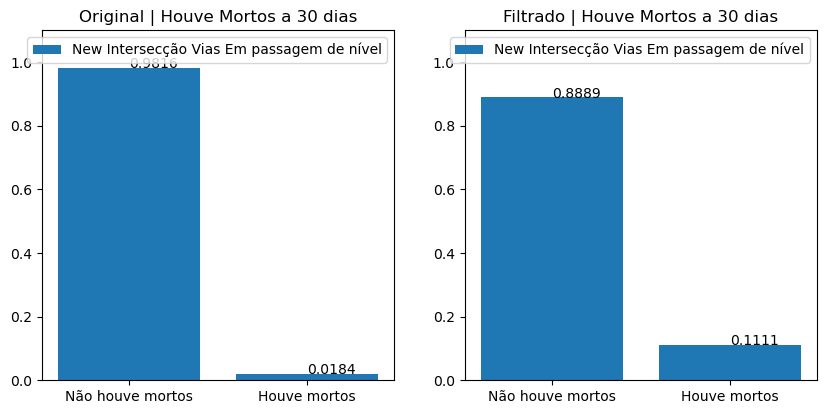

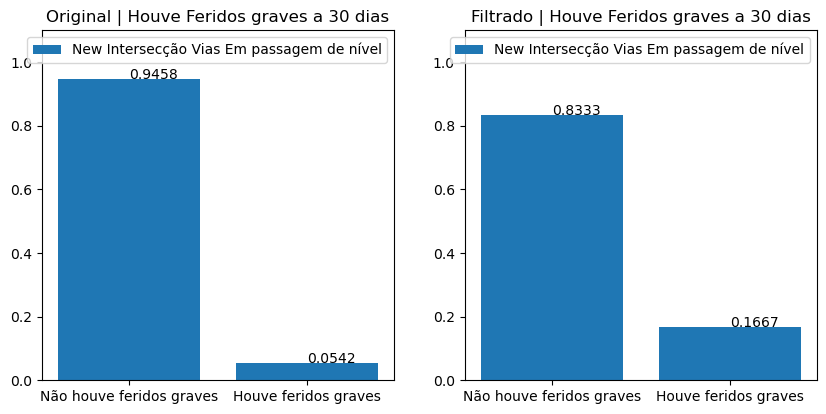

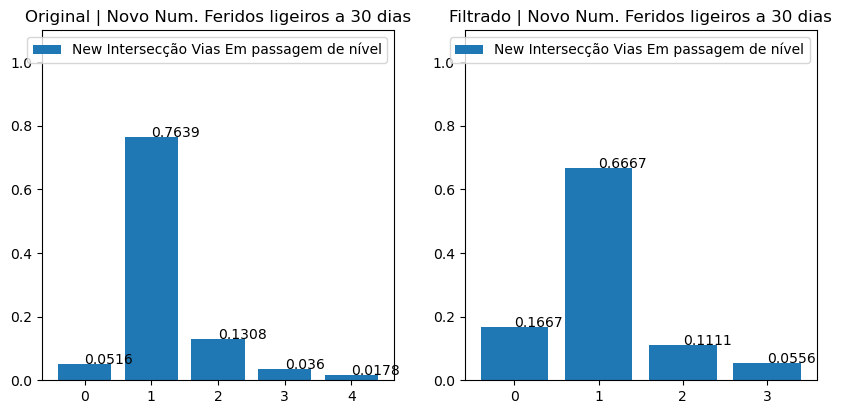

In [178]:
#Mês pode ser removido
check_se_feature_afeta_distribuicao()

In [184]:
df_test = open_sheet('final.xlsx')
df_test['Velocidade geral'].value_counts()

50.0     7406
90.0     1535
120.0     535
80.0      158
70.0      153
100.0     122
40.0       62
30.0       44
60.0       26
20.0       11
10.0        3
0.0         1
110.0       1
Name: Velocidade geral, dtype: int64